<a href="https://colab.research.google.com/github/cjakuc/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# Split train into train and val
from sklearn.model_selection import train_test_split

train, val = train_test_split(train,
                              train_size=0.90,
                              test_size=0.10,
                              stratify=train['status_group'],
                              random_state=42)

In [0]:
import numpy as np

def wrangle(X):
  """Wrangle, train, validate, and test sets in the same way"""

  X = X.copy()

  # Fix the variables w/ zeros
  X['latitude'] = X['latitude'].replace(-2e-08,0)
  cols_with_zeros = ['longitude','latitude',
                     'construction_year',
                     'gps_height',
                     'population',
                     'amount_tsh',
                     'public_meeting',
                     'scheme_management',
                     'scheme_name',
                     'permit']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  
  # Drop duplicate columns
  duplicates = ['quantity_group', 'payment_type', 'num_private']
  X = X.drop(columns=duplicates)

  # Drop recorded_by (never varies)
  unusable_variance = ['recorded_by']
  X = X.drop(columns=unusable_variance)
  
  # Change date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])

  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  
  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  # Return the wrangled dataframe
  return X

# Wrangle train, val, and test
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier


def full_pipe(train,val):
  """Define a function that selects features, pipes, encodes, imputes,
     and fits a random forest classifier 
     Returns the pipeline and features"""

  # Features:
  # Select features
  target = 'status_group'
  # Drop target & id from train columns
  train_features = train.drop(columns=[target, 'id'])
  # Get a list of numeric features
  numeric_features = train_features.select_dtypes(include='number').columns.tolist()
  # Get a series w/ the cardinality of nonnumeric features
  cardinality = train_features.select_dtypes(exclude='number').nunique()
  # Get a list of features w/ cardinality
  categorical_features = cardinality.index.tolist()
  # Combine the lists
  features = numeric_features + categorical_features
  
  # Arrange data into X features matrix and y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]

  # Pipeline
  pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=341,
                            random_state=42,
                            min_samples_leaf=5,
                            max_depth=25)
  )

  pipeline.fit(X_train, y_train)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

  return pipeline, features

In [12]:
pipeline, features = full_pipe(train,val)

Train Accuracy 0.8801720912832024
Validation Accuracy 0.8173400673400674


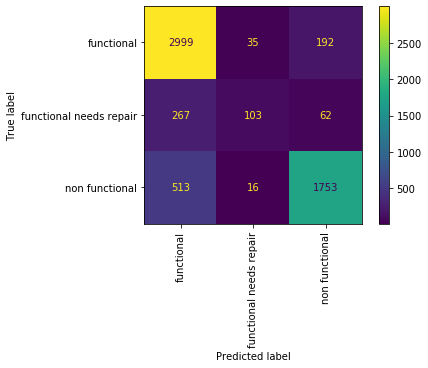

In [14]:
from sklearn.metrics import plot_confusion_matrix
X_val = val[features]
y_val = val['status_group']
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');